In [1]:
import numpy as np
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import seaborn as sns
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [2]:
def load_data():
    data = pd.read_pickle('../../data/dataframes/data.pkl')
    nomination_onehot = pd.read_pickle('../../data/dataframes/nomination_onehot.pkl')
    selected_performers_onehot = pd.read_pickle('../../data/dataframes/selected_performers_onehot.pkl')
    selected_directors_onehot = pd.read_pickle('../../data/dataframes/selected_directors_onehot.pkl')
    selected_studio_onehot = pd.read_pickle('../../data/dataframes/selected_studio_onehot.pkl')
    selected_scriptwriter_onehot = pd.read_pickle('../../data/dataframes/selected_scriptwriter_onehot.pkl')
    review_dataframe = pd.read_pickle('../../data/dataframes/review_dataframe.pkl')
    
    # selected_directors_onehotとselected_scriptwriter_onehotの重複した人
    duplicate_scriptwriter = set(selected_directors_onehot.columns) & set(selected_scriptwriter_onehot.columns)
    selected_scriptwriter_onehot = selected_scriptwriter_onehot.drop(duplicate_scriptwriter, axis=1)
    
    frames = [nomination_onehot,selected_performers_onehot,selected_directors_onehot,selected_studio_onehot,selected_scriptwriter_onehot]
    
    df = data
    for f in frames:
        df = pd.merge(df, f, on='id')
    
    drop_elements = ["director", "other_nominates", "performers", "production_studio", "scriptwriter", "title",  'selected_performers', 'selected_directors', 'selected_studio',
       'selected_scriptwriter']
    df_drop = df.drop(drop_elements, axis=1)

    return df_drop, data

In [3]:
def standard(x_train, x_test):
    stdsc = StandardScaler()

    # 訓練用のデータを標準化
    x_train_std = stdsc.fit_transform(x_train)
    # 訓練用データを基準にテストデータも標準化
    x_test_std = stdsc.transform(x_test)
    
    return x_train_std, x_test_std

In [4]:
# 多重共線性の排除 (共分散0.7以上のfeatureを削除)

def collinearity(X):

    # 改善前
#     cor=np.corrcoef(X.T)
#     type(cor)
#     plt.figure(figsize=(20, 20))
#     sns.heatmap(cor, vmin=0.70,vmax=1,cmap=plt.cm.Spectral_r)

    # 改善
    drop_clm = ['吉田一夫']
    X = X.drop(drop_clm,  axis=1)

    # 改善後
    
#     cor=np.corrcoef(X.T)
#     type(cor)
#     plt.figure(figsize=(20, 20))
#     sns.heatmap(cor, vmin=0.80,vmax=1,cmap=plt.cm.Spectral_r)
    
    return X

In [5]:
def data_processing(test_year):
    df, data = load_data()
    
    df = collinearity(df)
    
    train = df.loc[df["year"] != test_year]
    test = df.loc[df["year"] == test_year]
    
    # 入力データの作成
    y_train = train['prize'].ravel()
    x_train = train.drop(['prize', 'year'], axis=1)
    
    features = x_train.columns
    
    x_train = x_train.values # 学習データ
    
    # テストデータの作成
    y_test = test['prize'].ravel()
    x_test = test.drop(['prize', 'year'], axis=1)
    x_test = x_test.values # テストデータ

    # データの標準化
    x_train_std, x_test_std = standard(x_train, x_test)
    
    return x_train_std, x_test_std, y_train, y_test, features

In [6]:
def plot_roc_curve(fpr, tpr, auc):
    # ROC曲線をプロット
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

In [14]:
def lda():
    
    # 0.5以上 または 予測値の中の最大のもの を 1　その他を 0 として混同行列を作成する
    th_prob = 0.5
    
    cm_all = np.zeros((2, 2))
    
    # 予測した確率全体を格納
    probs_all = np.array([])
    y_true_all = np.array([])
    
    for y in range(1978, 2020):
        
        # データの生成
        x_train_std, x_test_std, y_train, y_test, features = data_processing(y)
        
        # 学習
        trained = LDA(solver="eigen", shrinkage=1).fit(x_train_std,  y_train)
        
        # 予測(確率)
        probs = trained.predict_proba(x_test_std)
        probs_all = np.hstack((probs_all, probs[:,1]))
        y_true_all = np.hstack((y_true_all, y_test))
        
        # 混同行列
        y_pred = np.where((probs[:,1] ==  max(probs[:,1])) | (probs[:,1] > th_prob), 1, 0) #確率→0/1
        cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
        cm_all += cm

    auc = roc_auc_score(y_true_all, probs_all)
    fpr, tpr, thresholds = roc_curve(y_true_all, probs_all)
    
    plot_roc_curve(fpr, tpr, auc)
    
    print("len: {0} , {1}".format(len(y_true_all), len(probs_all) ))
    print("confusion_matrix: ")
    print(cm_all)
    print("AUC: ")
    print(auc)

    return auc

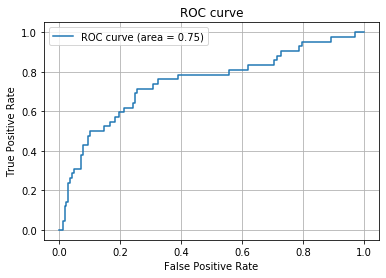

len: 211 , 211
confusion_matrix: 
[[148.  21.]
 [ 18.  24.]]
AUC: 
0.745280360664976


In [15]:
if __name__ == "__main__":
    lda()